In [5]:
import numpy as np
import pandas as pd
import random

from pprint import pprint

from scipy import linalg as LA
from scipy.optimize import minimize
from scipy.optimize import BFGS

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


In [86]:

ENTANGLER_MAP = [[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8]]
#ENTANGLER_MAP_QIDA= [[0,1],[1,2],[2,5],[5,8],[8,7],[7,6],[6,3]]
ENTANGLER_MAP_QIDA= [[0,1],[1,2],[2,5],[5,8],[7,8],[6,7],[3,6]]
ENTANGLER_MAP_3x4_A = [[0,1],[1,2],[8,9],[10,11]]

In [3]:
#EXTRACT RANDOM COLOR
def randomColor():
    color = random.randrange(0, 2**24)
    hex_color = hex(color)
    std_color = "#" + hex_color[2:]
    return std_color

In [97]:
#EXTRACT ONLY PARAMS t1 AND t2 OF THE N_BLOCK
def extract_N_block(paramslist,ent,depth,offset):
    ct = len(ent)
    n = len(set(np.array(ent).flatten()))
    paramslist = paramslist[n::]
    sliced = []
    for i in range(depth):
        for _ in range(ct):
            if i > (offset-1):
                sliced.append(paramslist[:6:])
            paramslist = paramslist[6::]
        paramslist = paramslist[n::]
    
    relevant = []
    for s in sliced:
        relevant.append(s[4:6:]) #[:2:] for firs couple (Ry,Ry on 1/2 quit) [2:4:] for second couple (entangling one 2 qubit) [4:6:] last couple
    if relevant == []:
        return [],  []
    else:
        relevant = list(np.concatenate(relevant).flat)
        x_ = relevant[::2]
        y_ = relevant[1::2]
        return x_,y_

In [10]:
#EXTRACT INDEX, ENERGIES and COLORS FOR EACH
def plt_energies(data:dict):
    i = []
    en = []
    for item in data:
        i.append(item['Index'])
        en.append(item['Energy'])
    return i,en

In [11]:
#SIMPLY COMPUTE STATS mean, min(best vqe), std and index of best vqe
def stats(e,i):
    return np.mean(e), np.min(e), np.std(e), np.where(e == np.min(e))[0][0]

In [12]:
#CLUSTER THE VQE BASED ON THE DIFFERENCE FROM THE BEST ONE
def threshold_cluster(en, cluster):
    m = np.min(en)
    M = np.max(en)
    n_th = cluster
    delta = np.abs(M - m)/n_th
    th = [m for _ in range(n_th)]
    th_colors = ['black', '#79002d', '#dc1e72', '#db6fb5', '#dbc8e2']
    l = []
    for j in range(n_th):
        th[j] = m+(delta*j)
    associations = []
    
    for e in en:
        for t in range(len(th)):
            if e<=th[t]:
                l.append(t)
                associations.append(th_colors[t])
                break
        else:

            l.append(len(th))
            associations.append(th_colors[-1])
    return associations, th_colors, delta,l


In [13]:
#CREATE LEGEND OF THE PLOT
def createLegend(cl,string):
    legend = []

    for item,i in enumerate(cl):
        legend.append(Line2D([0], [0], marker='o', color=cl[item], label=string.format(item), markersize=15))
    return legend



FIND THE OPTIMAL VQE FOR QIDA 
1 Layer, 7 entangling gates, 9 qubits


In [14]:

def extract_df(ent, r_col,f,size,depth):
    df = []
    for i in range(1,size+1):
        p = pd.read_pickle(f.format(i,depth))[0]
        x_,y_ = extract_N_block(p["Optimal_params"],ent, depth,0)
        data = dict()
        if r_col:
            c = randomColor()
            while len(c)!=7:
                c = randomColor()
        if r_col:
            data.update({"x_params":x_, "y_params":y_, "color": c,"Energy":p['Energy'],"Index": i })
        else:
            data.update({"x_params":x_, "y_params":y_, "Energy":p['Energy'], "Index": i })

        df.append(data)
    return df


In [15]:
#CHECK DI QUESTA FUNZIONE
#RIMOSSO INDICE
def clean_df(en,i):
    new_en = []
    new_i = []
    mean_e = np.mean(en)
    for e in range(len(en)):
        if mean_e>=en[e]:
            new_en.append(en[e])
            new_i.append(i[e])
        else:
            pass
    return new_i, new_en

In [16]:
#CREATE PARAMETERS PAIRS
def parameter_pair(df, i,ass):
    x_ = []
    y_ = []
    rep = len(df[0]['x_params'])
    for item in df:
        if item['Index'] in i:
            x_.append(item["x_params"])
            y_.append(item["y_params"])
    cmap = list()
    for item in ass:
        for _ in range(rep):
            cmap.append(item)

    return x_,y_,cmap

In [17]:
def parameter_pair_multilayer(color_list, reps):
    parameters_color = []
    for i in range(len(color_list)):
        for _ in range(reps[i]):
            parameters_color.append(color_list[i])
    return parameters_color

In [18]:
def size_plot (idx, s_min, s_all, l, rep):
    temp = []
    temp_a = []
    for i in range(l):
        if i == idx:
            temp.append(s_min)
            temp_a.append(1)
        else:
            
            temp.append(s_all)
            temp_a.append(0.4)
    s = []
    a = []
    for item in range(len(temp)):
        for _ in range(rep):
            s.append(temp[item])
            a.append(temp_a[item])
    return s, a

In [19]:
#SELECT ONLY SOME THRESHOLDS
def cut_th(en,i,col,l,th):
    new_en = []
    new_col = []
    new_i = [] 
    for j in range(len(l)):
        if l[j] < th:
            new_en.append(en[j])
            new_col.append(col[j])
            new_i.append(i[j])
    return new_en, new_i, new_col

CREAZIONE PLOT CON COLOMAp DIVISA PER SOGLIE

-4.8710346371122775
-4.8710346371122775 21
-4.8710346371122775 21


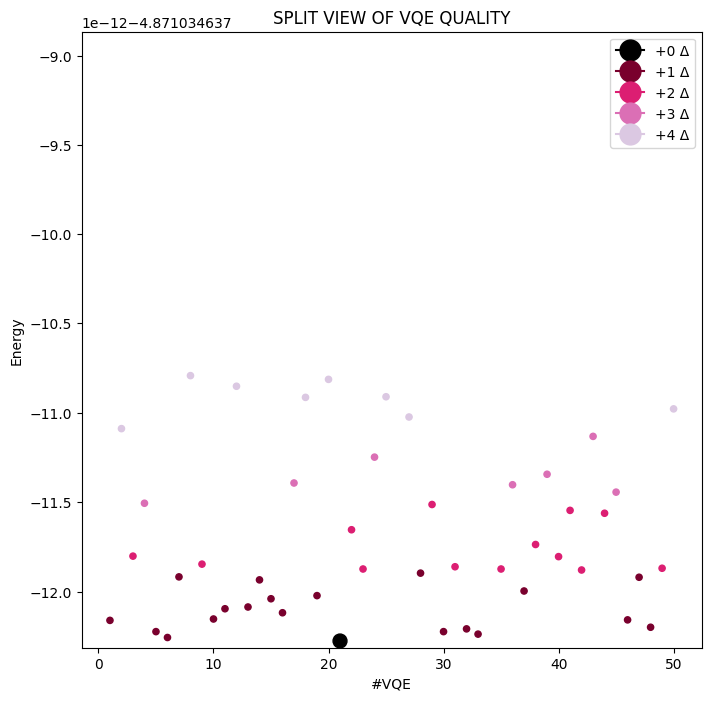

In [98]:

#file_qida = "./pickle/vqe{}_3x3_{}A+_SU4.pkl"

file_qida = "./pickle/{}_3x4_{}ASU4.pkl"
file_ladder = "./pickle/vqe{}_3x3_ladder_{}SU4.pkl"
system = '3x4'

df = extract_df(ent=ENTANGLER_MAP_3x4_A, r_col=False, f=file_qida, size = 50, depth=1)
i,en= plt_energies(data = df)
print(np.min(en))
_, best_vqe, vqe_std, best_vqe_ind = stats(en, i)
print(best_vqe, i[best_vqe_ind])
#i,en = clean_df(en,i)
col,legend_color,delta,l = threshold_cluster(en=en, cluster = 5)

stop_th = 5


en, i, col= cut_th(en=en,i=i, l=l, th=stop_th, col = col)
_,best_vqe,_, best_vqe_ind = stats(en, i)
print(best_vqe,i[best_vqe_ind])


plt.figure(figsize=(8, 8))
s = [20]*len(i)
s[best_vqe_ind] = 100


plt.scatter(i, en, s=s,c = col)

string = "+{} Δ"
plt.legend(handles=createLegend(legend_color[:stop_th],string))

#plt.xlim(0,len(en)+1)
if system == '3x3':
    plt.axhline(-4.7493272585529, c='b')
    plt.axhline(-3, c='r')
elif system =='3x4':
    plt.axhline(-6,69168019351493, c='b')
    plt.axhline(-0,25, c='r')
plt.ylim(np.min(en)-(delta/10), np.max(en)+(5*delta))

plt.xlabel('#VQE')
plt.ylabel('Energy')

plt.title('SPLIT VIEW OF VQE QUALITY')
plt.show()


48 48 192


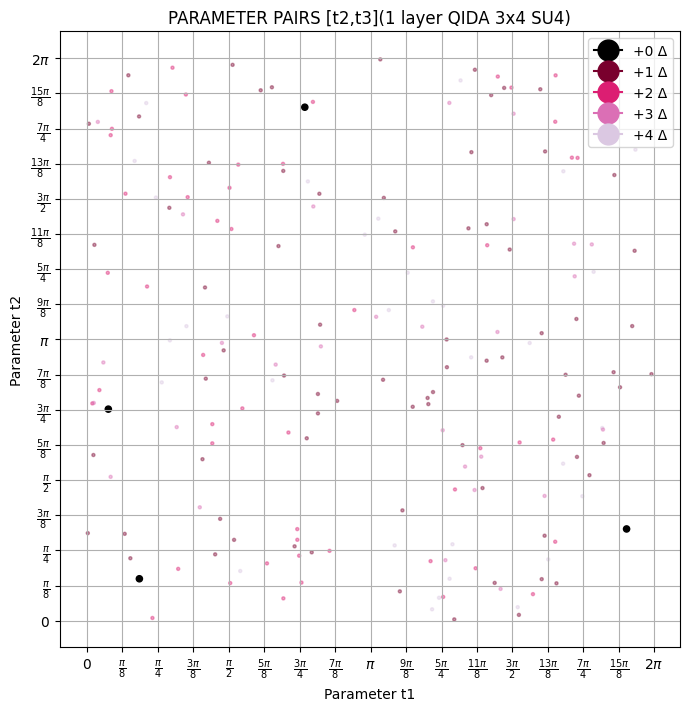

In [99]:
x_param, y_param, cmap = parameter_pair(df=df,i=i,ass = col)
print(len(x_param), len(y_param), len(cmap))
s, a = size_plot(idx=best_vqe_ind, s_min=20, s_all=5, l=len(en), rep = int(len(cmap)/len(en)))


plt.figure(figsize = (8,8))
plt.title("PARAMETER PAIRS [t2,t3](1 layer QIDA 3x4 SU4)")
string = "+{} Δ"
plt.legend(handles=createLegend(legend_color[:stop_th],string))

plt.scatter(np.mod(x_param,2*np.pi), np.mod(y_param, 2*np.pi), c=cmap, alpha=a, s=s)

plt.xticks(np.linspace(0, 2*np.pi, 17), [r'$0$',  r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$', r'$\frac{3\pi}{8}$', r'$\frac{\pi}{2}$', r'$\frac{5\pi}{8}$',
                                        r'$\frac{3\pi}{4}$', r'$\frac{7\pi}{8}$', r'$\pi}$', r'$\frac{9\pi}{8}$', r'$\frac{5\pi}{4}$', r'$\frac{11\pi}{8}$',
                                        r'$\frac{3\pi}{2}$', r'$\frac{13\pi}{8}$', r'$\frac{7\pi}{4}$', r'$\frac{15\pi}{8}$', r'$2\pi$'])
plt.yticks(np.linspace(0, 2*np.pi, 17), [r'$0$',  r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$', r'$\frac{3\pi}{8}$', r'$\frac{\pi}{2}$', r'$\frac{5\pi}{8}$',
                                        r'$\frac{3\pi}{4}$', r'$\frac{7\pi}{8}$', r'$\pi}$', r'$\frac{9\pi}{8}$', r'$\frac{5\pi}{4}$', r'$\frac{11\pi}{8}$',
                                        r'$\frac{3\pi}{2}$', r'$\frac{13\pi}{8}$', r'$\frac{7\pi}{4}$', r'$\frac{15\pi}{8}$', r'$2\pi$'])
plt.grid(True)
plt.xlabel('Parameter t1')
plt.ylabel('Parameter t2')
plt.show()

LADDER RESULTS


In [18]:

def extract_df_multidepth(depth,offset, ent,f,size):
    vqe_colors = []
    param_colors = []
    rep = []
    color_label  = ['black', '#79002d', '#dc1e72', '#db6fb5', '#fc9dbc','#dbc8e2','grey']
    total_x = []
    total_y = []
    en = []
    index = []
    
    for j in range(offset,depth+1):
        for i in range(1,size+1):
            p = pd.read_pickle(f.format(i,j))[0]
            x_,y_ = extract_N_block(p["Optimal_params"],ent, j,0)
            en.append(p["Energy"])
            total_x.append(x_)
            total_y.append(y_)
            for _ in range(len(x_)):
                param_colors.append(color_label[j-1])

            rep.append(len(x_))
            vqe_colors.append(color_label[j-1])
            index.append(i+(j-1)*size)
    return total_x, total_y, color_label, param_colors,vqe_colors,rep, index, en

In [25]:
file_ladder = "./pickle/vqe{}_3x3_ladder_{}SU4.pkl"

offset = 1
depth = 1
total_x,total_y,color_label,colors,vqe_colors,reps,index,en = extract_df_multidepth(depth=depth,offset=offset,ent=ENTANGLER_MAP, f=file_ladder, size = 50)
print(len(index), len(en))
total_x = list(np.concatenate(total_x).flat)
total_y = list(np.concatenate(total_y).flat)
print(reps)

50 50
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]


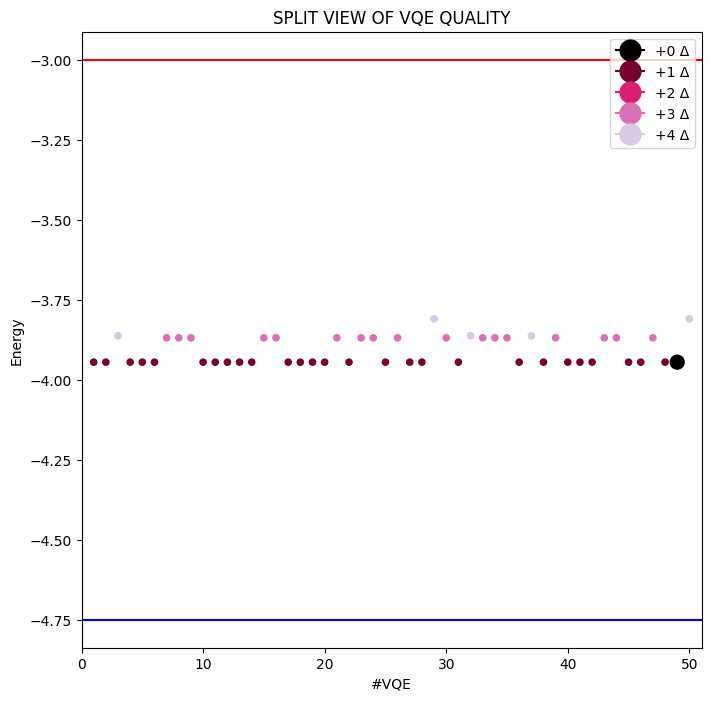

In [30]:
plt.figure(figsize=(8, 8))
s = 5
string = "{} layers"
if offset==depth:
    col,legend_color,delta,l = threshold_cluster(en=en, cluster = 5) 
    vqe_colors = col
    color_label = legend_color
    _,best_vqe,_, best_vqe_ind = stats(en, index)
    s = [20]*len(index)
    s[best_vqe_ind] = 100
    string = "+{} Δ"
    
plt.scatter(index, en, s=s,c=vqe_colors)

plt.axhline(-4.7493272585529, c='b')
plt.axhline(-3, c='r')
plt.legend(handles=createLegend(color_label, string))

plt.xlim(50*(offset-1),len(en)*(offset)+1)
#plt.ylim(np.min(en)-(delta/10), np.max(en)+(delta))

plt.xlabel('#VQE')
plt.ylabel('Energy')

plt.title('SPLIT VIEW OF VQE QUALITY')
plt.show()

50 50


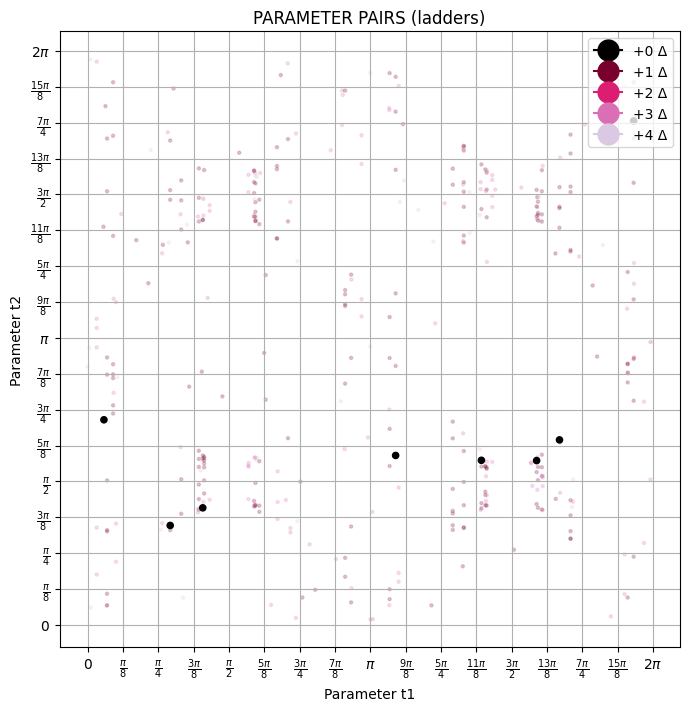

In [31]:
a = 1
s = 2
if depth == offset:
    colors = parameter_pair_multilayer(vqe_colors, reps)
    s, a = size_plot(idx=best_vqe_ind, s_min=20, s_all=5, l=len(en), rep = reps[0])  
plt.figure(figsize = (8,8))
plt.title("PARAMETER PAIRS (ladders)")
plt.legend(handles=createLegend(color_label, string))

plt.scatter(np.mod(total_x,2*np.pi), np.mod(total_y, 2*np.pi), c=colors, alpha=a, s=s)

plt.xticks(np.linspace(0, 2*np.pi, 17), [r'$0$',  r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$', r'$\frac{3\pi}{8}$', r'$\frac{\pi}{2}$', r'$\frac{5\pi}{8}$',
                                        r'$\frac{3\pi}{4}$', r'$\frac{7\pi}{8}$', r'$\pi}$', r'$\frac{9\pi}{8}$', r'$\frac{5\pi}{4}$', r'$\frac{11\pi}{8}$',
                                        r'$\frac{3\pi}{2}$', r'$\frac{13\pi}{8}$', r'$\frac{7\pi}{4}$', r'$\frac{15\pi}{8}$', r'$2\pi$'])
plt.yticks(np.linspace(0, 2*np.pi, 17), [r'$0$',  r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$', r'$\frac{3\pi}{8}$', r'$\frac{\pi}{2}$', r'$\frac{5\pi}{8}$',
                                        r'$\frac{3\pi}{4}$', r'$\frac{7\pi}{8}$', r'$\pi}$', r'$\frac{9\pi}{8}$', r'$\frac{5\pi}{4}$', r'$\frac{11\pi}{8}$',
                                        r'$\frac{3\pi}{2}$', r'$\frac{13\pi}{8}$', r'$\frac{7\pi}{4}$', r'$\frac{15\pi}{8}$', r'$2\pi$'])
plt.grid(True)
plt.xlabel('Parameter t1')
plt.ylabel('Parameter t2')
plt.show()

CLUSTER ROTATION MATRICES

In [44]:
# 1-QUBIT GATES
I = np.eye(2)
Z = np.array([[1., 0.],[0. ,-1.]])
X = np.array([[0., 1.],[1. ,0.]])
Y = np.array([[0., -1.j],[1.j ,0.]])

# 2-QUBITs GATES
I4 = np.eye(4)
CNOT1 = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
CNOT2 = np.array([[1,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0]])

CZ = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,-1]])

CY1 = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,-1j],[0,0,1j,0]])
CY2 = np.array([[1,0,0,0],[0,0,0,-1j],[0,0,1,0],[0,1j,0,0]])

CH1 = np.array([[1,0,0,0],[0,1,0,0],[0,0,1/np.sqrt(2),1/np.sqrt(2)],[0,0,1/np.sqrt(2),-1/np.sqrt(2)]])
CH2 = np.array([[1,0,0,0],[0,1/np.sqrt(2),0,1/np.sqrt(2)],[0,0,1,0],[0,1/np.sqrt(2),0,-1/np.sqrt(2)]])

SWAP = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])
iSWAP = np.array([[1,0,0,0],[0,0,1j,0],[0,1j,0,0],[0,0,0,1]])

M_LIST = [I4, 
          CNOT1, CNOT2,
          CZ,
          CY1,
          CY2,
          CH1,
          CH2,
          SWAP, iSWAP]


In [45]:
#COMPOSES RY(theta)
def ry(theta):
    a = np.cos(theta/2)
    b = np.sin(theta/2)
    return np.array([[a,-b],[b,a]])

#COMPOSES RZ(theta)
def rz(theta):
    a = np.exp(1j*theta/2)
    b = np.exp(-1J*theta/2)
    return np.array([[a,0],[0,b]])

In [71]:
#COMPOSE N_BLOCK (real) FROM PARAMETERS t1 AND t2
def compose_N_block_real(x):
    return CNOT2 @ np.kron(I, ry(x[0])) @ CNOT1 @ np.kron(I, ry(x[1])) @ CNOT2


#COMPOSE N_BLOCK FROM PARAMETERS t1, t2 AND t3
def compose_N_block(x):
    return CNOT2 @np.kron(rz(x[0]),I) @ np.kron(I, ry(x[1])) @ CNOT1 @ np.kron(I, ry(x[2])) @ CNOT2


#COMPOSE GENERAL SU(2) FROM PARAMETERS t1, t2 AND t3
def general_su2(x):
    return np.kron(rz(x[0]),I) @ np.kron(ry(x[1]),I) @ np.kron(ry(x[2]),I)


In [72]:
#COMPOSE SU(4) (real) FROM LIST OF PARAMETERS (6-params)
def compose_su4_real(params):
    return np.kron(ry(params[0]),I) @ np.kron(I, ry(params[1])) @ compose_N_block_real([params[2], params[3]]) @ np.kron(ry(params[4]),I) @ np.kron(I, ry(params[5]))

#COMPOSE SU(4) FROM LIST OF PARAMETERS (15 params)
def compose_su4(params):
    return np.kron(general_su2(params[:3:]),I) @ np.kron(I,general_su2(params[3:6:])) @ compose_N_block(params[6:9:]) @ np.kron(general_su2(params[9:12:]),I) @ np.kron(I,general_su2(params[12:15:]))


COMPUTE RY ROTATION FOR $$\theta \in \{0, \frac{\pi}{2}, \pi, \frac{3\pi}{2}\}$$

In [50]:
#COMPUTE THE RY ROTATION IN THE CENTER OF THE CLUSTER
halfs = [np.pi*k/2 for k in range(0,5)]
for i in halfs:
    print("Val:{}\n{}\n".format(i,np.round(ry(np.mod(i,2*np.pi)),4)))

Val:0.0
[[ 1. -0.]
 [ 0.  1.]]

Val:1.5707963267948966
[[ 0.7071 -0.7071]
 [ 0.7071  0.7071]]

Val:3.141592653589793
[[ 0. -1.]
 [ 1.  0.]]

Val:4.71238898038469
[[-0.7071 -0.7071]
 [ 0.7071 -0.7071]]

Val:6.283185307179586
[[ 1. -0.]
 [ 0.  1.]]



GENERAL $R_y(\theta)$ ROTATION IS DEFINED AS
$$R_y(\theta) = \begin{bmatrix}\cos(\frac{\theta}{2})&-\sin(\frac{\theta}{2})\\ \\\sin(\frac{\theta}{2})&\cos(\frac{\theta}{2})\end{bmatrix}$$

FOR $\theta = \pi$
$$R_y(\pi) = \begin{bmatrix}0&-1\\1&0\end{bmatrix} = -i\sigma_y$$

FOR $\frac{\pi}{2}+k\pi$
$$R_y(\frac{\pi}{2}) = \frac{1}{\sqrt{2}}\begin{bmatrix}1&-1\\1&1\end{bmatrix}$$
WHICH ACT LIKE:
$$R_y(\frac{\pi}{2})\ket{0}= \ket{+}$$
$$R_y(\frac{\pi}{2})\ket{1}= -\ket{-}$$
 
$\space$
 
$$R_y(\frac{3\pi}{2})\ket{0}= -\ket{-}$$
$$R_y(\frac{3\pi}{2})\ket{1}= -\ket{+}$$

In [84]:
#COMPUTE THE DIFFERENCE BETWEEN A COMPUTED MATRIX AND THE ABOVE 2-QUBIT MATRIX
def measure(a):
    all_diff = []
    for b in M_LIST:
        dist = LA.norm(a - b, 'fro')
        all_diff.append(dist)
    return all_diff

#COMPUTE THE DISTANCE BETWEEN DIFFERENT
def distance_su4(x):
    r = compose_su4_real(x)
    return np.real(LA.norm(CH2 - r, 'fro'))

In [85]:
convergence = []
parameters = []

def optimize():
    print("Starting Optimization!")
    def callback(x_params):
        convergence.append(distance_su4(x_params))
        print(convergence[-1])
        parameters.append(x_params)

    res = minimize(fun = distance_su4, 
                   x0 = np.random.uniform(size = 6, low=-np.pi, high=np.pi),
                   callback=callback,
                   tol=1e-6,
                   method='BFGS'
                   )
    parameters.append(res.x)
    return res.x, distance_su4(res.x)

par, dist = optimize()
print(par, dist)

print(np.round(compose_su4_real(par),3))

Starting Optimization!
1.369964655827018
1.2759078062570812
0.7543719742861702
0.6180185792545635
0.37668708501844766
0.20704476460312882
0.11252401645462147
0.06595825546389907
0.04658928429266147
0.04040900532393929
0.03248613228693854
0.018576124093683175
0.01476396648132075
0.008828926413076865
0.004974765665080871
0.004748991963795851
0.0043208622033131415
0.001907613785155917
0.0015724945462341137
0.0011722880366073158
0.0007113498694173718
0.0005375631857637053
0.00027009054643438245
0.00016315971960857795
0.00013407852588127617
9.059750242291416e-05
6.23605819204739e-05
5.082083026189602e-05
4.5314079030569354e-05
3.679998183307129e-05
2.1762880313942553e-05
1.0522762107828885e-05
7.820971408154309e-06
5.895132433912307e-06
4.653950080960228e-06
3.266449035868261e-06
2.9895630433262945e-06
2.480372169724532e-06
1.5318994007133644e-06
1.2607586811903268e-06
8.956933135867963e-07
4.713280820809417e-07
3.4236466215680933e-07
2.8231440001651663e-07
2.0104474873373654e-07
1.23029293